# Cell filtering of MISC pediatric samples 
## Input
### Samples
* Folder path: `./lucas_data`
* Each sample has a folder; naming pattern: sample name-BCR/TCR_VHT_cellranger
* Each sample has a `filtered_contig_annotations.csv` file; important columns:
  * **barcode**: each cell has a unique barcode
  * **contig_id**: each contig has a unique contig_id; multiple contigs may belong to one cell
  * **chain**:
    * For BCR data:
      * it can be either *IGH*, *IGK*, *IGL* or *Multi*
      * *IGH* means heavy chain; *IGK* and *IGL* means light chain
    * For TCR data:
      * it can be either *TRA*, *TRB* or *Multi*
      * *TRA* means alpha chain; *TRB* means beta chain
  * **umis**: count of UMI

### Changeo-10x output
* Folder path: `./lucas_data_changeo`
* Each sample has a folder; naming pattern: sample name
* Each sample has a `filtered_contig_heavy_productive-T.tsv` and `filtered_contig_light_productive-T.tsv` file; important columns:
  * **sequence_id**: corresponding to `contig_id` in `filtered_contig_annotations.csv` file
  * **sequence**: corresponding to contig sequence in `filtered_contig.fasta` file
  * **locus**:
    * For heavy data:
      * it can be either *TRB* or *TRD*
      * *TRB* corresponding to *TRB* of `chain` in `filtered_contig_annotations.csv` file
      * *TRD* corresponding to *Multi* of `chain` in `filtered_contig_annotations.csv` file
    * * For light data:
      * it can be either *TRA* or *TRG*
      * *TRA* corresponding to *TRA* of `chain` in `filtered_contig_annotations.csv` file
      * *TRG* corresponding to *Multi* of `chain` in `filtered_contig_annotations.csv` file
  * **cell_id**: corresponding to `barcode` in `filtered_contig_annotations.csv` file
  * **umi_count**: corresponding to `umis` in `filtered_contig_annotations.csv` file

### GEX data
* file: `./GEX.csv`
* important columns:
  * **sample**: sample name
  * **barcode**: cell barcode; pattern: cell barcode for MISC and HA data
  * **annotation**: cell type of this barcode
  
## Output
* Output folder: `lucas_filtered`
* Include 2 files:
  * `filtered_contig_heavy_productive-T.tsv`
  * `filtered_contig_light_productive-T.tsv`
  
## Filtering Criterion
* Step 0. Remove *Multi* contigs (not identifiable to *TRA* or *TRB*)
* Step 1. Filtering cell based on beta chain (B represents count of beta chains in one cell, A represents alpha chain)
  * B=0: remove cell
  * B=1: keep cell, even nUMI<4
  * B>1: keep the beta chain with the highest nUMI (nUMI must >=4) and remove other contigs. If the highest nUMI<4, remove cell and all contigs
  * **A>1: keep the alpha chain with the highest nUMI and remove other contigs. No matter how low the highest nUMI is**
* Step 2. Filtering cell based on sample contamination
  * Identify barcodes across pairs of samples
  * Based on the filtered data from Step 1
  * Remove barcodes from both samples with identical contig sequences (after Step 1, each barcode will have only 1 beta chain)
* Step 3. Filtering cell based on sample overlap
  * Identify barcodes appeared in both BCR and TCR data within the same sample
  * Based on the filtered data from Step 1
  * When check barcodes in BCR do not consider the heavy/light chain counts
  * Check the cell type for all cells
  * Overlap barcodes will be kept; **no filtering** applied
  * Add sample name behind the cell barcode and contig id

## Import packages

In [1]:
from IPython.display import display
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()
from shutil import rmtree

## Specify folder

In [2]:
# samples folder
input_folder = r'./lucas_data'
# changeo-10x folder
changeo_folder = r'./lucas_data_changeo'
# GEX file
gex_file = 'GEX.csv'
# output folder
output_folder = r'./lucas_filtered'
if os.path.isdir(output_folder):
    rmtree(output_folder)
os.mkdir(output_folder)

## Prepare data for filtering

### Define sample object

In [3]:
class Sample:
    def __init__(self, tcr, bcr, changeo):
        self.tcr = tcr 
        self.bcr = bcr
        self.changeo = changeo

### Read samples

In [4]:
samples = {}
sample_names = set()

for f in os.listdir(changeo_folder):
    
    sample_names.add(f)
    
    # sample folder name has a pattern: sample name-BCR/TCR_VHT_cellranger
    this_tcr = pd.read_csv(os.path.join(input_folder, f+'-TCR_VHT_cellranger', 'filtered_contig_annotations.csv'))
    # bcr maybe missing
    try:
        this_bcr = pd.read_csv(os.path.join(input_folder, f+'-BCR_VHT_cellranger', 'filtered_contig_annotations.csv'))
    except:
        this_bcr = pd.DataFrame(columns=this_tcr.columns)
        
    this_changeo = pd.concat([pd.read_csv(os.path.join(changeo_folder, f, 'filtered_contig_heavy_productive-T.tsv'), sep='\t'),
                              pd.read_csv(os.path.join(changeo_folder, f, 'filtered_contig_light_productive-T.tsv'), sep='\t')],
                              ignore_index=True)
    
    samples[f] = Sample(this_tcr, this_bcr, this_changeo)
    
del this_bcr, this_tcr, this_changeo    
    
sample_names = sorted(sample_names)
        
print('Total {} samples'.format(len(sample_names)))
print('Total {} datasets'.format(len(samples)))

Total 18 samples
Total 18 datasets


### GEX data

In [5]:
if gex_file is None:
    gex = pd.DataFrame(columns=['annotation', 'barcode', 'sample'])
else:
    gex = pd.read_csv(gex_file)
    
# add a column for matching
for i in gex.index:
    gex.at[i, 'for_match'] = gex.at[i, 'barcode'] + '_' + gex.at[i, 'sample']

## Initial Statistics

In [6]:
# store import overall statistics of each sample
stats_df = pd.DataFrame(columns=['sample name', 'nCellBegin', 'nContigBegin', 'nCellChangeo', 'nContigChangeo'])

for i, name in enumerate(sample_names):
    stats_df.at[i, 'sample name'] = name
    stats_df.at[i, 'nCellBegin'] = len(set(samples[name].tcr['barcode']))
    stats_df.at[i, 'nContigBegin'] = len(set(samples[name].tcr['contig_id']))
    stats_df.at[i, 'nCellChangeo'] = len(set(samples[name].changeo['cell_id']))
    stats_df.at[i, 'nContigChangeo'] = len(set(samples[name].changeo['sequence_id']))
    
stats_df.set_index('sample name', inplace=True)
stats_df.loc['Total', :]= stats_df.sum(axis=0)
display(stats_df)

,nCellBegin,nContigBegin,nCellChangeo,nContigChangeo
sample name,,,,
HD_32M,6172,15294,6171,12701
HD_35F,6908,16946,6905,14063
HD_36M,4977,12353,4975,9993
NC-13F,6091,15892,6089,12637
Y111-1,1782,4210,1782,3317
Y113-1,2676,6604,2674,5436
Y117-1,1130,2566,1129,2111
Y117-R,5735,14760,5732,11684
Y124-1,3792,8826,3784,7129


## Step 0. Remove *Multi* contigs (not identifiable to *TRA* or *TRB*)

In [7]:
# store import overall statistics of each sample
stats_df = pd.DataFrame(columns=['sample name', 'nCellChangeoAfterRemoveMulti', 'nContigAfterRemoveMulti'])

for i, name in enumerate(sample_names):
    stats_df.at[i, 'sample name'] = name
    # replace the data with fitered data
    samples[name].changeo = samples[name].changeo[samples[name].changeo['locus'].isin(set(['TRA', 'TRB']))]
    stats_df.at[i, 'nCellChangeoAfterRemoveMulti'] = len(set(samples[name].changeo['cell_id']))
    stats_df.at[i, 'nContigAfterRemoveMulti'] = len(set(samples[name].changeo['sequence_id']))

stats_df.set_index('sample name', inplace=True)
stats_df.loc['Total', :]= stats_df.sum(axis=0)
display(stats_df)

,nCellChangeoAfterRemoveMulti,nContigAfterRemoveMulti
sample name,,
HD_32M,6171,12663
HD_35F,6905,14028
HD_36M,4975,9966
NC-13F,6089,12590
Y111-1,1782,3310
Y113-1,2674,5419
Y117-1,1129,2105
Y117-R,5732,11644
Y124-1,3784,7116


## Step 1. Filtering cell based on beta chain
B represents count of beta chains in one cell
* B=0: remove cell
* B=1: keep cell, even nUMI<4
* B>1: keep the beta chain with the highest nUMI (nUMI must >=4) and remove other contigs. If the highest nUMI<4, remove cell and all contigs
* **A>1: keep the alpha chain with the highest nUMI and remove other contigs. No matter how low the highest nUMI is**

In [8]:
def getUMI(sample_type, data_df):
    '''get umis from dataframe
    sample_type: BCR or TCR
    dataframe contains 4 columns:
        barcode: each cell has a unique barcode
        contig_id: each contig has a unique contig_id. Multiple contigs may belong to one cell
        chain: for BCR data, it can be either "IGH", "IGK", "IGL" or "Multi"
                   "IGH" means heavy chain; "IGK" and "IGL" means light chain
               for TCR data, it can be either "TRA", "TRB" or "Multi"
                   "TRA" means alpha chain; "TRB" means beta chain
        umis: count of UMI
    all column names have been changed to corresponding named in changeo result
    '''
    
    # determine heavy or beta string
    if sample_type == 'BCR':
        short_chains = set(['IGK', 'IGL'])
        long_chains = set(['IGH'])
    elif sample_type == 'TCR':
        short_chains = set(['TRA'])
        long_chains = set(['TRB'])
        
    cell_dict = {}
    for i in data_df.index:
        this_cell_id = data_df.at[i, 'cell_id']
        if this_cell_id not in cell_dict:
            cell_dict[this_cell_id] = {'nHeavy/Beta': 0,
                                       'nMulti': 0,
                                       'nLight/Alpha': 0,
                                       'BLargestUMI': 0,
                                       'BLargestContigID': '',
                                       'ALargestUMI': 0,
                                       'ALargestContigID': ''}

        if data_df.at[i, 'locus'] in long_chains:
            # it is heavy/beta chain, need record it
            cell_dict[this_cell_id]['nHeavy/Beta'] += 1
            # use the larget umi counts
            if data_df.at[i, 'umi_count'] > cell_dict[this_cell_id]['BLargestUMI']:
                cell_dict[this_cell_id]['BLargestUMI'] = data_df.at[i, 'umi_count']
                cell_dict[this_cell_id]['BLargestContigID'] = data_df.at[i, 'sequence_id']
                
        elif data_df.at[i, 'locus'] in short_chains:
            # it is light/alpha chain, need record it
            cell_dict[this_cell_id]['nLight/Alpha'] += 1
            if data_df.at[i, 'umi_count'] > cell_dict[this_cell_id]['ALargestUMI']:
                cell_dict[this_cell_id]['ALargestUMI'] = data_df.at[i, 'umi_count']
                cell_dict[this_cell_id]['ALargestContigID'] = data_df.at[i, 'sequence_id']
            
        elif data_df.at[i, 'locus'] == 'Multi':
            # it is multi chain, also need record it
            cell_dict[this_cell_id]['nMulti'] += 1
            # light chain passed
    
    return cell_dict

def dict2df(sample_type, cell_dict):
        '''convert a special dict to dataframe
        '''
        
        frames = []
        for barcode, sample_dict in cell_dict.items():
            frames.append({'barcode': barcode,
                           'BUMI': sample_dict['BLargestUMI'],
                           'nHeavy/Beta': sample_dict['nHeavy/Beta'],
                           'nLight/Alpha': sample_dict['nLight/Alpha'],
                           'nMulti': sample_dict['nMulti'],
                           'BLargestContigID': sample_dict['BLargestContigID'],
                           'AUMI': sample_dict['ALargestUMI'],
                           'ALargestContigID': sample_dict['ALargestContigID']
                           })
        df = pd.DataFrame(frames)
        if sample_type == 'BCR':
            df.rename(columns={'BUMI': 'BCR_heavy_largest_UMI',
                               'AUMI': 'BCR_light_largets_UMI',
                           'nHeavy/Beta': 'nHeavy',
                           'nLight/Alpha': 'nLight',
                           'nMulti': 'nMultiBCR',
                           'BLargestContigID': 'HeavyLargestContigID',
                           'ALargestContigID': 'LightLargestContigIDBCR'}, inplace=True)
        elif sample_type == 'TCR':
            df.rename(columns={'BUMI': 'TCR_beta_largest_UMI',
                               'AUMI': 'TCR_alpha_largets_UMI',
                           'nHeavy/Beta': 'nBeta',
                           'nLight/Alpha': 'nAlpha',
                           'nMulti': 'nMultiTCR',
                           'BLargestContigID': 'BetaLargestContigID',
                           'ALargestContigID': 'AlphaLargestContigID'}, inplace=True)
        return df

In [9]:
cell_chain_dfs = {}  # store statistics of chains by cell

for name in sample_names:
    cell_chain_dfs[name] = dict2df('TCR', getUMI('TCR', samples[name].changeo))

### Beta chain statistics of TCR by cell

In [10]:
def statsByCell(df):
    '''statistics respect to beta chain
    '''
    
    stats = {}
    
    # cells with B=0
    stats['B=0,A>=0'] = df[df['nBeta']==0].shape[0]
    
    # cells with B=1
    tmp_df = df[df['nBeta']==1]
    # A=0
    stats['B=1,A=0'] = tmp_df[tmp_df['nAlpha']==0].shape[0]
    # A=1
    stats['B=1,A=1'] = tmp_df[tmp_df['nAlpha']==1].shape[0]
    # A>1
    stats['B=1,A>1'] = tmp_df[tmp_df['nAlpha']>1].shape[0]
    
    # cells with B>1
    tmp_df = df[df['nBeta']>1]
    # A=0
    stats['B>1,A=0'] = tmp_df[tmp_df['nAlpha']==0].shape[0]
    # A=1
    stats['B>1,A=1'] = tmp_df[tmp_df['nAlpha']==1].shape[0]
    # A>1
    stats['B>1,A>1'] = tmp_df[tmp_df['nAlpha']>1].shape[0]
    
    return stats

In [11]:
cell_beta_stats = []

for sample_name, stats_df in cell_chain_dfs.items():
    tmp_dict = statsByCell(stats_df)
    tmp_dict['sample name'] = sample_name
    cell_beta_stats.append(tmp_dict)

cell_beta_stats = pd.DataFrame(cell_beta_stats)
cell_beta_stats.set_index('sample name', inplace=True)
cell_beta_stats.loc['Total',:]= cell_beta_stats.sum(axis=0)
cell_beta_stats['Total']= cell_beta_stats.sum(axis=1)
print('Summary of cell counts by alpha and beta chain')
display(cell_beta_stats)

Summary of cell counts by alpha and beta chain


,"B=0,A>=0","B=1,A=0","B=1,A=1","B=1,A>1","B>1,A=0","B>1,A=1","B>1,A>1",Total
sample name,,,,,,,,
HD_32M,108.0,715.0,4370.0,530.0,36.0,238.0,174.0,6171.0
HD_35F,161.0,872.0,4836.0,512.0,33.0,272.0,219.0,6905.0
HD_36M,90.0,753.0,3383.0,412.0,28.0,195.0,114.0,4975.0
NC-13F,78.0,674.0,4310.0,612.0,41.0,213.0,161.0,6089.0
Y111-1,28.0,398.0,1186.0,109.0,11.0,41.0,9.0,1782.0
Y113-1,42.0,334.0,1907.0,247.0,12.0,77.0,55.0,2674.0
Y117-1,39.0,246.0,710.0,81.0,13.0,32.0,8.0,1129.0
Y117-R,93.0,631.0,4198.0,527.0,17.0,173.0,93.0,5732.0
Y124-1,123.0,790.0,2451.0,236.0,25.0,118.0,41.0,3784.0


### Filtering cells and contigs based on beta chain

In [12]:
def filterBetaChain(data_df, contig_stats_df):
    '''filter cells by beta chain
    all column names have been changed to corresponding named in changeo result
    '''
    
    # B = 0, exclude, barcode set
    barcode_b0 = set(contig_stats_df[contig_stats_df['nBeta']==0]['barcode'])
    
    # B = 1, keep
    
    # B > 1, barcode with multi beta chain
    barcode_b2_exclude = set()  # exclude barcodes
    barcode_b2_keep = set()  # keep barcodes
    multib_keep = {}  # contig id for keep barcodes
    
    # A >1, barcode with multi alpha chain
    barcode_a2_keep = set()  # keep barcodes
    multia_keep = {}  # contig id for keep barcodes
    
    
    # deal tiwh B >1
    tmp_multib_raw_data = contig_stats_df[contig_stats_df['nBeta']>1]
    for j in tmp_multib_raw_data.index:
        if tmp_multib_raw_data.at[j, 'TCR_beta_largest_UMI'] >= 4:
            multib_keep[tmp_multib_raw_data.at[j, 'barcode']] = tmp_multib_raw_data.at[j, 'BetaLargestContigID']
            barcode_b2_keep.add(tmp_multib_raw_data.at[j, 'barcode'])
        else:
            barcode_b2_exclude.add(tmp_multib_raw_data.at[j, 'barcode'])
            
    # deal with A > 1
    tmp_multib_raw_data = contig_stats_df[contig_stats_df['nAlpha']>1]
    for j in tmp_multib_raw_data.index:
        multia_keep[tmp_multib_raw_data.at[j, 'barcode']] = tmp_multib_raw_data.at[j, 'AlphaLargestContigID']
        barcode_a2_keep.add(tmp_multib_raw_data.at[j, 'barcode'])
    
    stat_dict = {}
    stat_dict['nRemoveCellNoBeta'] = len(barcode_b0)
    stat_dict['nRemoveCellMultiBetaUMI<4'] = len(barcode_b2_exclude)
    
    
    # begin filtering
    nContigNoBeta = 0 # contig with no beta chain
    nContigUMI4 = 0 # contig with beta chain umi<4
    nContigNoTopBeta = 0 # contig beta chain umi not the largest
    nContigNoTopAlpha = 0 # contig alpha chain umi not the largest
    
    # iterate each row/contig
    data_df['exclude'] = 0
    for j in data_df.index:
        # whether cell has no beta chain
        if data_df.at[j, 'cell_id'] in barcode_b0:
            data_df.at[j, 'exclude'] = 1
            nContigNoBeta += 1
        # whether cell has multi beta chain but umi<4
        if data_df.at[j, 'cell_id'] in barcode_b2_exclude:
            data_df.at[j, 'exclude'] = 1
            nContigUMI4 += 1
        # if this row is still kept, further look it
        if data_df.at[j, 'exclude'] == 0:
            # whether it is a multi/beta/alpha chain
            # multi chain has been removed
            if data_df.at[j, 'locus'] == 'TRA':
                # further determine if this cell has multi beta chain
                if data_df.at[j, 'cell_id'] in barcode_a2_keep:
                    # multi alpha chain. Is it the one with largest umi?
                    if not (data_df.at[j, 'sequence_id'] == multia_keep[data_df.at[j, 'cell_id']]):
                        # not the largest one, removed
                        data_df.at[j, 'exclude'] = 1
                        nContigNoTopAlpha += 1
                    # otherwise, the largest one, keep
                # otherwise, cell has 0 or 1 alpha chain, keep
                
            elif data_df.at[j, 'locus'] == 'TRB':
                # further determine if this cell has multi beta chain
                if data_df.at[j, 'cell_id'] in barcode_b2_keep:
                    # multi beta chain. Is it the one with largest umi?
                    if not (data_df.at[j, 'sequence_id'] == multib_keep[data_df.at[j, 'cell_id']]):
                        # not the largest one, removed
                        data_df.at[j, 'exclude'] = 1
                        nContigNoTopBeta += 1
                    # otherwise, the largest one, keep
                # otherwise, cell has only 1 beta chain, keep
    
    # record statistics
    stat_dict['nRemoveContigNoBeta'] = nContigNoBeta
    stat_dict['nRemoveContigMultiBetaUMI<4'] = nContigUMI4
    stat_dict['nRemoveContigMultiBetaNotLargestUMI'] = nContigNoTopBeta
    stat_dict['nRemoveContigMultiAlphaNotLargestUMI'] = nContigNoTopAlpha
    
    # total exclude contigs
    remain_df = data_df[data_df['exclude']==0]
    
    stat_dict['nCellRemain'] = len(set(remain_df['cell_id']))
    stat_dict['nContigRemain'] = len(set(remain_df['sequence_id']))
    
    return remain_df.drop(['exclude'], axis=1), stat_dict

In [13]:
tcr_overall_stats_dicts = {}

for sample_name, stats_df in cell_chain_dfs.items():
    tmp_df, tmp_dict = filterBetaChain(samples[sample_name].changeo, stats_df)
    # replace the data with fitered data
    samples[sample_name].changeo = tmp_df
    # combine dict
    tmp_dict['sample name'] = sample_name
    tcr_overall_stats_dicts[sample_name] = tmp_dict

### Summary the filtering of beta chain

In [14]:
tcr_overall_stats_dicts = pd.DataFrame([v for k, v in tcr_overall_stats_dicts.items()])
tcr_overall_stats_dicts.set_index('sample name', inplace=True)
tcr_overall_stats_dicts.loc['Total', :]= tcr_overall_stats_dicts.sum(axis=0)
print('Summary of the filtering by beta chain')
display(tcr_overall_stats_dicts)

Summary of the filtering by beta chain


,nRemoveCellNoBeta,nRemoveCellMultiBetaUMI<4,nRemoveContigNoBeta,nRemoveContigMultiBetaUMI<4,nRemoveContigMultiBetaNotLargestUMI,nRemoveContigMultiAlphaNotLargestUMI,nCellRemain,nContigRemain
sample name,,,,,,,,
HD_32M,108.0,20.0,121.0,59.0,436.0,709.0,6043.0,11338.0
HD_35F,161.0,22.0,169.0,70.0,510.0,738.0,6722.0,12541.0
HD_36M,90.0,11.0,97.0,29.0,335.0,534.0,4874.0,8971.0
NC-13F,78.0,16.0,86.0,40.0,404.0,776.0,5995.0,11284.0
Y111-1,28.0,4.0,30.0,9.0,58.0,119.0,1750.0,3094.0
Y113-1,42.0,3.0,48.0,10.0,143.0,305.0,2629.0,4913.0
Y117-1,39.0,8.0,40.0,19.0,46.0,90.0,1082.0,1910.0
Y117-R,93.0,11.0,99.0,31.0,275.0,629.0,5628.0,10610.0
Y124-1,123.0,17.0,141.0,48.0,171.0,278.0,3644.0,6478.0


## Step 2. Filtering cell based on sample contamination
* Identify barcodes across pairs of samples
* Based on the filtered data from Step 1
* Remove barcodes from both samples with identical contig sequences (after Step 1, each barcode will have only 1 beta chain)

### Check barcodes shared in pair of samples

In [15]:
def filterCellInPairSamples(data_dfs, sample_names):
    '''get cell barcodes which are included in 2 samples
    after filtering of Step 1, each barcode must have only 1 beta chain
    data_dfs is a dict; key: sample name; value: a object containing raw annotation data
    '''
    
    barcode_per_sample = {}  # store barcode id for each sample
    barcode_pair_samples = {}  # store barcode shared across 2 samples
    nbarcode_pair_samples = pd.DataFrame(columns=sample_names)  # dataframe store count of share barcodes

    # read all barcodes
    for sample_name in sample_names:
        barcode_per_sample[sample_name] = set(data_dfs[sample_name].changeo['cell_id'])
        nbarcode_pair_samples.loc[sample_name, :] = np.nan
    
    # iterate on each sample
    for i in range(len(sample_names)):
        first_sample = sample_names[i]
        for j in range(i+1, len(sample_names)):
            second_sample = sample_names[j]
            # fill the lower triangular matrix
            barcode_pair_samples[(second_sample, first_sample)] = barcode_per_sample[first_sample].intersection(barcode_per_sample[second_sample])
            nbarcode_pair_samples.loc[second_sample, first_sample] = len(barcode_pair_samples[(second_sample, first_sample)])
    
    # add total row
    nbarcode_pair_samples.loc['Total', :]= nbarcode_pair_samples.sum(axis=0)
    
    # change the diagonal to the count of cell in this sample
    for sample_name in sample_names:
        nbarcode_pair_samples.loc[sample_name, sample_name] = len(barcode_per_sample[sample_name])
    
    # change the type from object to float for plot
    nbarcode_pair_samples = nbarcode_pair_samples.astype('float')
    
    print('Total {:.0f} cell barcodes appeared in any 2 samples, and will be further checked by contig sequence'.format(
    nbarcode_pair_samples.loc['Total', :].sum()))
    nbarcode_pair_samples.to_csv('SampleContaminationBeforeSeqCheck.csv')
    print('Counts of cell barcodes across 2 samples saved into csv file "SampleContaminationBeforeSeqCheck.csv"')
    print('Counts of cell barcodes across 2 samples after Step 1 filtering by beta chains')
    
    # show the matrix
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(12.8/2, 9.6/2))
        # all white, no color
        sns.heatmap(nbarcode_pair_samples, annot=True, fmt='.0f', mask=nbarcode_pair_samples.isnull(),
                    cmap=ListedColormap(['white']), cbar=False)
        ax.xaxis.tick_top()
        plt.xticks(rotation=45)
    
    return barcode_pair_samples, nbarcode_pair_samples

### 1st batch
* Y111-1
* Y113-1
* HD_32M
* HD_35F
* HD_36M

In [16]:
subset = ['HD_32M', 'HD_35F', 'HD_36M', 'Y111-1', 'Y113-1']
sub_samples = {}

for name in subset:
    sub_samples[name] = samples[name]

Total 231 cell barcodes appeared in any 2 samples, and will be further checked by contig sequence
Counts of cell barcodes across 2 samples saved into csv file "SampleContaminationBeforeSeqCheck.csv"
Counts of cell barcodes across 2 samples after Step 1 filtering by beta chains


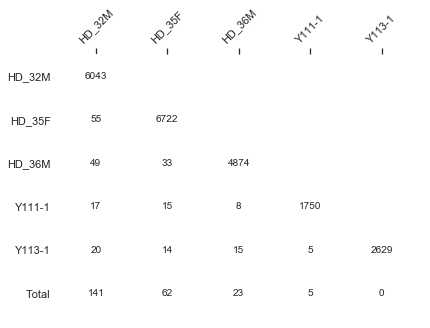

In [17]:
# raw annotation infos after filtering in Step 1 stored in dict samples
# sample names stored in list sample_names
barcode_pair_samples, nbarcode_pair_samples = filterCellInPairSamples(sub_samples, subset)

### Check contig sequence of shared barcodes
* If the contig sequences are identical, remove barcodes from both samples

Total 0 cell barcodes appeared in any 2 samples, and after checking by contig sequence
Counts of cell barcodes across 2 samples saved into csv file "SampleContaminationAfterSeqCheck.csv"
Counts of cell barcodes across 2 samples after checking contig sequence identity


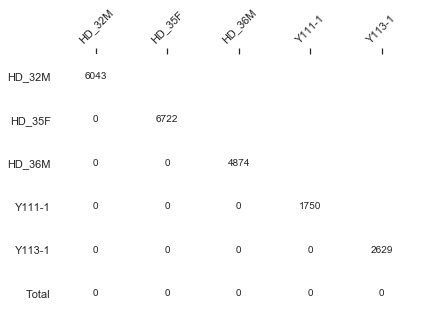

In [18]:
# raw annotation infos stored in dict samples
# sequences stored in samples too
for sample_pair, barcode_set in barcode_pair_samples.items():
    if len(barcode_set) > 0:
        first_sample = sample_pair[0]
        second_sample = sample_pair[1]
        new_barcode_set = set()  # store the new barcode which should be removed
        tmp_first_df = samples[first_sample].changeo
        tmp_second_df = samples[second_sample].changeo
        for barcode in barcode_set:
            # find the corresponding contig id in both samples
            first_index = (tmp_first_df['cell_id']==barcode) & (tmp_first_df['locus']=='TRB')
            if tmp_first_df[first_index].shape[0] > 1:
                raise Exception('Error: Multiple beta chains')
            first_seq = tmp_first_df[first_index]['sequence'].values[0]
            
            second_index = (tmp_second_df['cell_id']==barcode) & (tmp_second_df['locus']=='TRB')
            if tmp_second_df[second_index].shape[0] > 1:
                raise Exception('Error: Multiple beta chains')
            second_seq = tmp_second_df[second_index]['sequence'].values[0]

            if first_seq == second_seq:
                new_barcode_set.add(barcode)
            
        # update counts and files
        barcode_pair_samples[(first_sample, second_sample)] = new_barcode_set
        nbarcode_pair_samples.loc[first_sample, second_sample] = len(new_barcode_set)
    
# update the total row
# make a deep copy
tmp_df = nbarcode_pair_samples.copy()
# change the diagonal to np.nan
for sample_name in sample_names:
    tmp_df.loc[sample_name, sample_name] = np.nan
tmp_df.drop(['Total'], inplace=True)
tmp_df.loc['Total', :] = tmp_df.sum(axis=0)
nbarcode_pair_samples.loc['Total', :] = tmp_df.loc['Total', :]

# show result
print('Total {:.0f} cell barcodes appeared in any 2 samples, and after checking by contig sequence'.format(
nbarcode_pair_samples.loc['Total', :].sum()))
nbarcode_pair_samples.to_csv('SampleContaminationAfterSeqCheck.csv')
print('Counts of cell barcodes across 2 samples saved into csv file "SampleContaminationAfterSeqCheck.csv"')
print('Counts of cell barcodes across 2 samples after checking contig sequence identity')
    
# show the matrix
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12.8/2, 9.6/2))
    # all white, no color
    sns.heatmap(nbarcode_pair_samples, annot=True, fmt='.0f', mask=nbarcode_pair_samples.isnull(),
                    cmap=ListedColormap(['white']), cbar=False)
    ax.xaxis.tick_top()
    plt.xticks(rotation=45)

### Save cell barcode which should be removed

In [19]:
barcode_remove_for_double = {}

for sample_pair, barcode_set in barcode_pair_samples.items():
    first_sample = sample_pair[0]
    second_sample = sample_pair[1]
    
    # remove cell barcode in both samples
    if first_sample in barcode_remove_for_double:
        barcode_remove_for_double[first_sample] = barcode_remove_for_double[first_sample].union(barcode_set)
    else:
        barcode_remove_for_double[first_sample] = barcode_set
    
    if second_sample in barcode_remove_for_double:
        barcode_remove_for_double[second_sample] = barcode_remove_for_double[second_sample].union(barcode_set)
    else:
        barcode_remove_for_double[second_sample] = barcode_set

### 2nd batch

In [20]:
subset2 = ['Y117-1', 'Y124-1', 'Y125-1', 'Y127-1', 'Y129-1', 'Y117-R', 'Y124-R',
           'NC-13F', 'Y54-4', 'Y70-4', 'Y28-2', 'Y28-4', 'Y29-2']
sub_samples2 = {}

for name in subset2:
    sub_samples2[name] = samples[name]

Total 2123 cell barcodes appeared in any 2 samples, and will be further checked by contig sequence
Counts of cell barcodes across 2 samples saved into csv file "SampleContaminationBeforeSeqCheck.csv"
Counts of cell barcodes across 2 samples after Step 1 filtering by beta chains


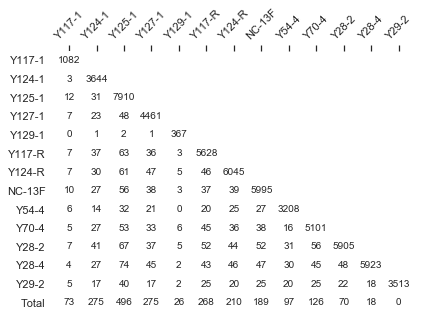

In [21]:
# raw annotation infos after filtering in Step 1 stored in dict samples
# sample names stored in list sample_names
barcode_pair_samples, nbarcode_pair_samples = filterCellInPairSamples(sub_samples2, subset2)

Total 0 cell barcodes appeared in any 2 samples, and after checking by contig sequence
Counts of cell barcodes across 2 samples saved into csv file "SampleContaminationAfterSeqCheck.csv"
Counts of cell barcodes across 2 samples after checking contig sequence identity


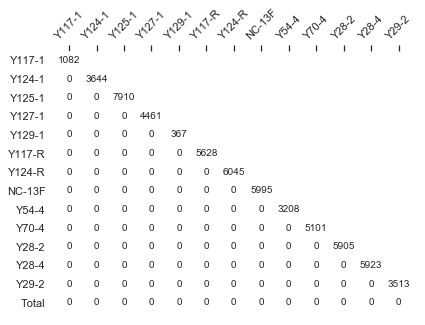

In [22]:
# raw annotation infos stored in dict samples
# sequences stored in samples too
for sample_pair, barcode_set in barcode_pair_samples.items():
    if len(barcode_set) > 0:
        first_sample = sample_pair[0]
        second_sample = sample_pair[1]
        new_barcode_set = set()  # store the new barcode which should be removed
        tmp_first_df = samples[first_sample].changeo
        tmp_second_df = samples[second_sample].changeo
        for barcode in barcode_set:
            # find the corresponding contig id in both samples
            first_index = (tmp_first_df['cell_id']==barcode) & (tmp_first_df['locus']=='TRB')
            if tmp_first_df[first_index].shape[0] > 1:
                raise Exception('Error: Multiple beta chains')
            first_seq = tmp_first_df[first_index]['sequence'].values[0]
            
            second_index = (tmp_second_df['cell_id']==barcode) & (tmp_second_df['locus']=='TRB')
            if tmp_second_df[second_index].shape[0] > 1:
                raise Exception('Error: Multiple beta chains')
            second_seq = tmp_second_df[second_index]['sequence'].values[0]

            if first_seq == second_seq:
                new_barcode_set.add(barcode)
            
        # update counts and files
        barcode_pair_samples[(first_sample, second_sample)] = new_barcode_set
        nbarcode_pair_samples.loc[first_sample, second_sample] = len(new_barcode_set)
    
# update the total row
# make a deep copy
tmp_df = nbarcode_pair_samples.copy()
# change the diagonal to np.nan
for sample_name in sample_names:
    tmp_df.loc[sample_name, sample_name] = np.nan
tmp_df.drop(['Total'], inplace=True)
tmp_df.loc['Total', :] = tmp_df.sum(axis=0)
nbarcode_pair_samples.loc['Total', :] = tmp_df.loc['Total', :]

# show result
print('Total {:.0f} cell barcodes appeared in any 2 samples, and after checking by contig sequence'.format(
nbarcode_pair_samples.loc['Total', :].sum()))
nbarcode_pair_samples.to_csv('SampleContaminationAfterSeqCheck.csv')
print('Counts of cell barcodes across 2 samples saved into csv file "SampleContaminationAfterSeqCheck.csv"')
print('Counts of cell barcodes across 2 samples after checking contig sequence identity')
    
# show the matrix
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12.8/2, 9.6/2))
    # all white, no color
    sns.heatmap(nbarcode_pair_samples, annot=True, fmt='.0f', mask=nbarcode_pair_samples.isnull(),
                    cmap=ListedColormap(['white']), cbar=False)
    ax.xaxis.tick_top()
    plt.xticks(rotation=45)

### Add cell barcode which should be removed to existed dict

In [23]:
for sample_pair, barcode_set in barcode_pair_samples.items():
    first_sample = sample_pair[0]
    second_sample = sample_pair[1]
    
    # remove cell barcode in both samples
    if first_sample in barcode_remove_for_double:
        barcode_remove_for_double[first_sample] = barcode_remove_for_double[first_sample].union(barcode_set)
    else:
        barcode_remove_for_double[first_sample] = barcode_set
    
    if second_sample in barcode_remove_for_double:
        barcode_remove_for_double[second_sample] = barcode_remove_for_double[second_sample].union(barcode_set)
    else:
        barcode_remove_for_double[second_sample] = barcode_set

In [24]:
del subset, subset2, sub_samples, sub_samples2

## Step 3. Filtering cell based on sample overlap
* Identify barcodes appeared in both BCR and TCR data within the same sample
* Based on the filtered data from Step 1
* When check barcodes in BCR do not consider the heavy/light chain counts
* Check the cell type for all cells
* Overlap barcodes will be kept; **no filtering** applied
* Add sample name behind the cell barcode and contig id

### Rename cell barcodes in excluding list in Step 2

In [25]:
for name, lst in barcode_remove_for_double.items():
    tmp_lst = list(lst)
    for i in range(len(tmp_lst)):
        tmp_lst[i] = tmp_lst[i] + '_' + name
    barcode_remove_for_double[name] = set(tmp_lst)

### Rename cell barcode and contig id

In [26]:
for name in sample_names:
    for i in samples[name].changeo.index:
        samples[name].changeo.at[i, 'cell_id'] = samples[name].changeo.at[i, 'cell_id'] + '_' + name
        samples[name].changeo.at[i, 'sequence_id'] = samples[name].changeo.at[i, 'sequence_id'] + '_' + name

### Add cell type info

In [27]:
for name in sample_names:
    samples[name].changeo = pd.merge(samples[name].changeo, gex, how='left',
                                    left_on='cell_id', right_on='for_match')
    samples[name].changeo.drop(columns=['sample', 'barcode', 'for_match'], inplace=True)

### Get overlaped cell barcode

In [28]:
# raw annotation infos after filtering in Step 1 stored in dict samples
# all samples included BCR and TCR stored in dict samples
tmp_dict = []
barcode_remove_for_overlap = {}

for name in sample_names:
    
    barcode_remove_for_overlap[name] = set()

    # get the overlap barcodes
    barcode_tcr = set(samples[name].changeo['cell_id'])
    barcode_bcr = list(set(samples[name].bcr['barcode']))
    # bcr barcode add sample name
    for i in range(len(barcode_bcr)):
        barcode_bcr[i] = barcode_bcr[i] + '_' + name
    barcode_bcr = set(barcode_bcr)
    barcode_overlap = barcode_tcr.intersection(barcode_bcr)
    
    # find cell type for each barcode
    for barcode in barcode_overlap:
        cell_type = samples[name].changeo[(samples[name].changeo['cell_id']==barcode) &
                                          (samples[name].changeo['locus']=='TRB')]['annotation'].values[0]
        if pd.isnull(cell_type):
            cell_type = 'Missing'
        
        tmp_dict.append({'barcode': barcode,
                         'sample name': name,
                         'cell type': cell_type})

tmp_dict = pd.DataFrame(tmp_dict)
# statistics
print('Total {} overlap cells'.format(tmp_dict.shape[0]))
# save cell type
if tmp_dict.shape[0] > 0:
    cell_distribution = tmp_dict.groupby(['cell type'])['cell type'].count()
    display(cell_distribution.to_frame(name='count'))

Total 1974 overlap cells


,count
cell type,
CD4 memory,51
CD4 naive I,12
CD4 naive II,10
CD56bright CD16dim NK,1
CD8 effector,11
CD8 memory,20
CD8 naive,21
Classical monocytes,12
MAIT-NKT cells,10


## Step 4. Perform filtering based on result of Step 2. and Step 3.

In [29]:
# cell barcode should be removed for sample contamination stored in barcode_remove_for_double
# cell barcode should be removed for overlap between BCR and TCR data stored in barcode_remove_for_overlap
# raw annotation infos after filtering in Step 1 stored in dict samples

stats_dict_list = []

for sample_name in sample_names:
    
    stats_dict_list.append({'sample name': sample_name})
    # get remain cells from step 1
    stats_dict_list[-1]['nCellRemainFromStep1'] = len(set(samples[sample_name].changeo['cell_id']))
    stats_dict_list[-1]['nCellRemoveContamination'] = len(barcode_remove_for_double[sample_name])
    stats_dict_list[-1]['nCellRemoveOverlap'] = len(barcode_remove_for_overlap[sample_name])
    
    # exclude barcodes
    exclude = barcode_remove_for_double[sample_name].union(barcode_remove_for_overlap[sample_name])
    
    samples[sample_name].changeo = samples[sample_name].changeo[~samples[sample_name].changeo['cell_id'].isin(exclude)]
    stats_dict_list[-1]['nCellRemainFinal'] = len(set(samples[sample_name].changeo['cell_id']))
    stats_dict_list[-1]['nContigRemainFinal'] = len(set(samples[sample_name].changeo['sequence_id']))
    
    # save csv file
    if not(os.path.isdir(os.path.join(output_folder, sample_name))):
        os.mkdir(os.path.join(output_folder, sample_name))
    samples[sample_name].changeo[samples[sample_name].changeo['locus']=='TRA'].to_csv(
        os.path.join(output_folder, sample_name, 'filtered_contig_light_productive-T.tsv'), index=False, sep='\t')
    samples[sample_name].changeo[samples[sample_name].changeo['locus']=='TRB'].to_csv(
        os.path.join(output_folder, sample_name, 'filtered_contig_heavy_productive-T.tsv'), index=False, sep='\t')
    

stats = pd.DataFrame(stats_dict_list)
stats.set_index('sample name', inplace=True)
stats.loc['Total', :]= stats.sum(axis=0)
print('Summary of the filtering by contamination and overlap')
display(stats)

Summary of the filtering by contamination and overlap


,nCellRemainFromStep1,nCellRemoveContamination,nCellRemoveOverlap,nCellRemainFinal,nContigRemainFinal
sample name,,,,,
HD_32M,6043.0,0.0,0.0,6043.0,11338.0
HD_35F,6722.0,0.0,0.0,6722.0,12541.0
HD_36M,4874.0,0.0,0.0,4874.0,8971.0
NC-13F,5995.0,0.0,0.0,5995.0,11284.0
Y111-1,1750.0,0.0,0.0,1750.0,3094.0
Y113-1,2629.0,0.0,0.0,2629.0,4913.0
Y117-1,1082.0,0.0,0.0,1082.0,1910.0
Y117-R,5628.0,0.0,0.0,5628.0,10610.0
Y124-1,3644.0,0.0,0.0,3644.0,6478.0


### Cell type distribution at cell level

In [30]:
cell_stats = []

for name in sample_names:
    
    # record the cell type distribution at cell level
    tmp_df = samples[name].changeo.drop_duplicates(['cell_id'])
    tmp_dict = tmp_df['annotation'].value_counts(dropna=False).to_dict()
    
    # exclude samples with no cell type info
    if len(tmp_dict) <= 1:
        continue
        
    tmp_dict['sample name'] = name
    cell_stats.append(tmp_dict)
    
cell_dis = pd.DataFrame(cell_stats)
cell_dis.set_index('sample name', inplace=True)
cell_dis = cell_dis.T
cell_dis.sort_index(inplace=True)
cell_dis.loc['Total', :] = cell_dis.sum(axis=0)
cell_dis.loc[:, 'Total'] = cell_dis.sum(axis=1)
print('Cell count:')
display(cell_dis)

Cell count:


sample name,HD_32M,HD_35F,HD_36M,NC-13F,Y111-1,Y113-1,Y117-1,Y117-R,Y124-1,Y124-R,Y125-1,Y127-1,Y129-1,Y28-2,Y28-4,Y29-2,Y54-4,Y70-4,Total
CD4 memory,1001.0,1516.0,829.0,1035.0,208.0,430.0,200.0,1153.0,635.0,965.0,1256.0,766.0,60.0,869.0,815.0,526.0,664.0,1140.0,14068.0
CD4 naive I,1095.0,1053.0,792.0,1405.0,125.0,330.0,168.0,971.0,765.0,1389.0,1588.0,641.0,35.0,1218.0,1506.0,868.0,831.0,1149.0,15929.0
CD4 naive II,654.0,594.0,453.0,791.0,81.0,204.0,97.0,483.0,454.0,747.0,896.0,429.0,29.0,860.0,1059.0,650.0,380.0,745.0,9606.0
CD56bright CD16dim NK,13.0,9.0,11.0,5.0,2.0,3.0,NaN,5.0,1.0,14.0,4.0,2.0,NaN,9.0,24.0,5.0,1.0,14.0,122.0
CD56dim CD16bright NK,49.0,71.0,47.0,40.0,20.0,4.0,3.0,31.0,5.0,43.0,21.0,54.0,1.0,34.0,17.0,17.0,8.0,21.0,486.0
CD8 effector,1111.0,527.0,417.0,116.0,323.0,292.0,32.0,258.0,30.0,117.0,137.0,725.0,41.0,400.0,210.0,96.0,104.0,180.0,5116.0
CD8 memory,320.0,610.0,393.0,342.0,71.0,116.0,40.0,404.0,114.0,313.0,273.0,265.0,15.0,233.0,171.0,122.0,152.0,244.0,4198.0
CD8 naive,826.0,617.0,393.0,1358.0,352.0,562.0,164.0,761.0,884.0,1568.0,2655.0,486.0,98.0,684.0,780.0,524.0,593.0,474.0,13779.0
Classical monocytes,99.0,71.0,72.0,68.0,24.0,30.0,8.0,81.0,38.0,70.0,39.0,46.0,5.0,71.0,36.0,42.0,11.0,100.0,911.0
Erythroid,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
